In [23]:
import cv2
from skimage.util import random_noise
import numpy as np
from matplotlib import pyplot as plt
from typing import Tuple, Optional


R: 40, G: 49, B: 48


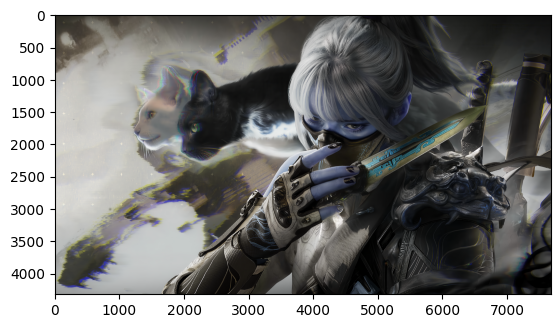

In [ ]:
img = cv2.imread("image.png") # 读取图像
(b, g, r) = img[100, 100] # 访问像素值
print("R: {}, G: {}, B: {}".format(r, g, b)) # OpenCV使用BGR颜色空间，而不是RGB
plt.imshow(img)
plt.show()

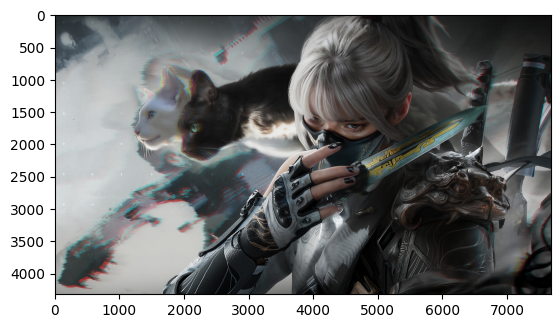

In [ ]:
rgb_img = cv2.cvtColor(img, cv2. COLOR_BGR2RGB) # BGR转换为RGB
plt.imshow(rgb_img) # 显示图像
plt.show()

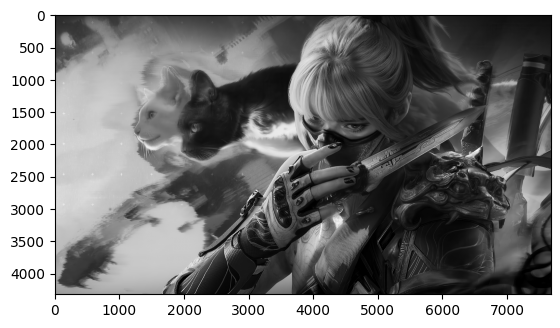

In [ ]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # 转换为灰度图
plt.imshow(gray_img, cmap='gray') # 显示灰度图
plt.show()

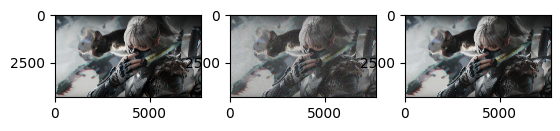

In [ ]:
sp_noise_img = random_noise(rgb_img, mode='s&p', amount=0.3) # 添加椒盐噪声
gus_noise_img = random_noise(rgb_img, mode='gaussian') # 添加高斯噪声
plt.subplot(1,3,1)
plt.imshow(rgb_img,cmap='gray')
plt.subplot (1,3,2)
plt.imshow(sp_noise_img, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(gus_noise_img,cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.1185624468230845e-15..1.0000000000000007].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.251971697046226e-15..1.0000000000000007].


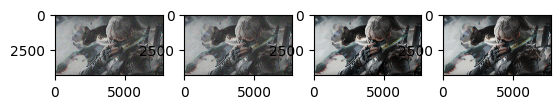

In [10]:
mean_3 = cv2.blur(sp_noise_img, (3,3))
mid_3 = cv2.medianBlur((sp_noise_img * 255). astype(np.uint8),3)
gus_3 = cv2.blur(gus_noise_img, (3,3))
plt.subplot(1,4,1)
plt.imshow(sp_noise_img, cmap='gray')
plt.subplot(1,4,2)
plt.imshow(mean_3, cmap='gray')
plt.subplot(1,4,3)
plt.imshow(mid_3, cmap='gray')
plt.subplot (1,4,4)
plt.imshow(gus_3, cmap='gray')

In [24]:
def gaussian_blur(src: np.ndarray, ksize: Tuple[int, int], sigmaX: float, 
                  sigmaY: Optional[float] = None, borderType: int = 0) -> np.ndarray:
    """
    高斯滤波，完全兼容cv2.GaussianBlur
    
    参数:
        src: 输入图像，可以是单通道或多通道(如RGB)
        ksize: 高斯核大小(width, height)，必须是正奇数
        sigmaX: X方向的高斯核标准差
        sigmaY: Y方向的高斯核标准差，如果为None或0，则等于sigmaX
        borderType: 边界处理方式(默认0为BORDER_DEFAULT)
    
    返回:
        滤波后的图像
    """
    # 参数检查
    if ksize[0] % 2 == 0 or ksize[1] % 2 == 0:
        raise ValueError("ksize must be odd numbers")
    if ksize[0] <= 0 or ksize[1] <= 0:
        raise ValueError("ksize must be positive")
    
    # 处理sigmaY
    if sigmaY is None or sigmaY == 0:
        sigmaY = sigmaX
    
    # 如果sigma为0，根据ksize计算
    if sigmaX <= 0:
        sigmaX = 0.3 * ((ksize[0] - 1) * 0.5 - 1) + 0.8
    if sigmaY <= 0:
        sigmaY = 0.3 * ((ksize[1] - 1) * 0.5 - 1) + 0.8
    
    # 生成高斯核
    kernel = _get_gaussian_kernel_2d(ksize, sigmaX, sigmaY)
    
    # 应用卷积
    return _convolve2d(src, kernel, borderType)


def blur(src: np.ndarray, ksize: Tuple[int, int], 
         anchor: Optional[Tuple[int, int]] = None, borderType: int = 0) -> np.ndarray:
    """
    均值滤波，完全兼容cv2.blur
    
    参数:
        src: 输入图像，可以是单通道或多通道(如RGB)
        ksize: 核大小(width, height)
        anchor: 锚点位置，默认为核中心(-1, -1)
        borderType: 边界处理方式(默认0为BORDER_DEFAULT)
    
    返回:
        滤波后的图像
    """
    # 参数检查
    if ksize[0] <= 0 or ksize[1] <= 0:
        raise ValueError("ksize must be positive")
    
    # 创建均值核（归一化的全1矩阵）
    kernel = np.ones((ksize[1], ksize[0]), dtype=np.float64) / (ksize[0] * ksize[1])
    
    # 应用卷积
    return _convolve2d(src, kernel, borderType, anchor)


def median_blur(src: np.ndarray, ksize: int) -> np.ndarray:
    """
    中值滤波，完全兼容cv2.medianBlur
    
    参数:
        src: 输入图像，可以是单通道或多通道(如RGB)
        ksize: 核大小，必须是大于1的正奇数
    
    返回:
        滤波后的图像
    """
    # 参数检查
    if ksize % 2 == 0:
        raise ValueError("ksize must be odd")
    if ksize <= 1:
        raise ValueError("ksize must be greater than 1")
    
    # 获取图像维度
    if len(src.shape) == 2:
        # 单通道图像
        return _median_filter_single_channel(src, ksize)
    elif len(src.shape) == 3:
        # 多通道图像，分别处理每个通道
        channels = src.shape[2]
        result = np.zeros_like(src)
        for c in range(channels):
            result[:, :, c] = _median_filter_single_channel(src[:, :, c], ksize)
        return result
    else:
        raise ValueError("Invalid image dimensions")


def _get_gaussian_kernel_2d(ksize: Tuple[int, int], sigmaX: float, sigmaY: float) -> np.ndarray:
    """生成2D高斯核"""
    kx, ky = ksize
    
    # 生成x和y方向的1D高斯核
    x = np.arange(kx) - (kx - 1) / 2
    y = np.arange(ky) - (ky - 1) / 2
    
    # 计算高斯函数值
    gauss_x = np.exp(-x**2 / (2 * sigmaX**2))
    gauss_y = np.exp(-y**2 / (2 * sigmaY**2))
    
    # 归一化
    gauss_x = gauss_x / gauss_x.sum()
    gauss_y = gauss_y / gauss_y.sum()
    
    # 生成2D核
    kernel = np.outer(gauss_y, gauss_x)
    
    return kernel


def _convolve2d(src: np.ndarray, kernel: np.ndarray, borderType: int = 0,
                anchor: Optional[Tuple[int, int]] = None) -> np.ndarray:
    """
    2D卷积操作，支持多通道图像
    """
    # 处理锚点
    if anchor is None or anchor == (-1, -1):
        anchor = (kernel.shape[1] // 2, kernel.shape[0] // 2)
    
    # 获取图像和核的尺寸
    kernel_h, kernel_w = kernel.shape
    
    # 处理单通道和多通道图像
    if len(src.shape) == 2:
        # 单通道图像
        return _convolve_single_channel(src, kernel, borderType, anchor)
    elif len(src.shape) == 3:
        # 多通道图像，分别处理每个通道
        channels = src.shape[2]
        result = np.zeros_like(src)
        for c in range(channels):
            result[:, :, c] = _convolve_single_channel(src[:, :, c], kernel, borderType, anchor)
        return result
    else:
        raise ValueError("Invalid image dimensions")


def _convolve_single_channel(src: np.ndarray, kernel: np.ndarray, 
                             borderType: int, anchor: Tuple[int, int]) -> np.ndarray:
    """单通道图像的卷积"""
    h, w = src.shape
    kernel_h, kernel_w = kernel.shape
    
    # 计算填充大小
    pad_h = kernel_h // 2
    pad_w = kernel_w // 2
    
    # 边界填充 (BORDER_DEFAULT = BORDER_REFLECT_101)
    if borderType in [0, 4]:  # BORDER_DEFAULT or BORDER_REFLECT_101
        padded = np.pad(src, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')
    elif borderType == 1:  # BORDER_REPLICATE
        padded = np.pad(src, ((pad_h, pad_h), (pad_w, pad_w)), mode='edge')
    elif borderType == 2:  # BORDER_REFLECT
        padded = np.pad(src, ((pad_h, pad_h), (pad_w, pad_w)), mode='symmetric')
    else:  # 默认使用reflect
        padded = np.pad(src, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')
    
    # 执行卷积
    result = np.zeros((h, w), dtype=np.float64)
    
    for i in range(h):
        for j in range(w):
            # 提取窗口
            window = padded[i:i+kernel_h, j:j+kernel_w]
            # 卷积计算
            result[i, j] = np.sum(window * kernel)
    
    # 保持与输入相同的数据类型
    if src.dtype == np.uint8:
        result = np.clip(result, 0, 255).astype(np.uint8)
    
    return result


def _median_filter_single_channel(src: np.ndarray, ksize: int) -> np.ndarray:
    """单通道图像的中值滤波"""
    h, w = src.shape
    pad = ksize // 2
    
    # 边界填充（使用reflect模式）
    padded = np.pad(src, pad, mode='reflect')
    
    # 执行中值滤波
    result = np.zeros((h, w), dtype=src.dtype)
    
    for i in range(h):
        for j in range(w):
            # 提取窗口
            window = padded[i:i+ksize, j:j+ksize]
            # 计算中值
            result[i, j] = np.median(window)
    
    return result

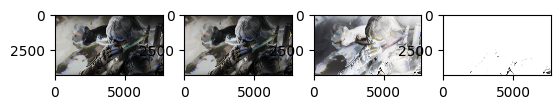

In [25]:
mean_3 = blur(sp_noise_img, (3, 3))
mid_3 = median_blur((sp_noise_img * 255).astype(np.uint8), 3)
gus_3 = blur(gus_noise_img, (3, 3))
plt.subplot(1,4,1)
plt.imshow(sp_noise_img, cmap='gray')
plt.subplot(1,4,2)
plt.imshow(mean_3, cmap='gray')
plt.subplot(1,4,3)
plt.imshow(mid_3, cmap='gray')
plt.subplot (1,4,4)
plt.imshow(gus_3, cmap='gray')